In [1]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/Dominik/R-workspace/cecelia/inst')

# MacOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# config
import py.config_utils as cfg

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec

from skimage.data import chelsea, hubble_deep_field
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import (
    calibrate_denoiser,
    denoise_wavelet,
    denoise_tv_chambolle,
    denoise_nl_means,
    estimate_sigma,
)
from skimage.util import img_as_float, random_noise
from skimage.color import rgb2gray
from functools import partial
from skimage.restoration import denoise_invariant
_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)

In [3]:
# get 3P image
base_dir = '/Volumes/Analysis_SSD/Dominik/cecelia/projects/QZwVFQ/ANALYSIS'

zero_dir = os.path.join(base_dir, '0/55LPuJ/')
im_path = os.path.join(zero_dir, 'ccidImage.ome.zarr')
#im_path = os.path.join(zero_dir, 'ccidSlidingWindow.zarr')
version_num = 1
task_dir = os.path.join(base_dir, str(version_num), '55LPuJ')

In [4]:
import py.zarr_utils as zarr_utils

# get array
im, _ = zarr_utils.open_as_zarr(im_path)
im = im[0]

In [5]:
import py.ome_xml_utils as ome_xml_utils
from py.dim_utils import DimUtils

omexml = ome_xml_utils.parse_meta(im_path)
dim_utils = DimUtils(omexml)
dim_utils.calc_image_dimensions(im.shape)

[91, 12, 8, 512, 512]
[512, 512, 8, 12, 91]
['X', 'Y', 'C', 'Z', 'T']


In [50]:
# get slices
slices = [slice(None) for _ in range(len(im.shape))]
slices[dim_utils.dim_idx('C')] = 2
slices[dim_utils.dim_idx('T')] = 24
#slices[dim_utils.dim_idx('Z')] = 0
#slices[dim_utils.dim_idx('X')] = slice(200, 400, 1)
#slices[dim_utils.dim_idx('Y')] = slice(200, 400, 1)
slices = tuple(slices)

In [51]:
import matplotlib.pyplot as plt

from skimage.restoration import denoise_wavelet, estimate_sigma, denoise_tv_chambolle, denoise_bilateral
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio

In [52]:
sigma = 0.12
image = im[slices]

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(image, channel_axis=None, average_sigmas=True)
sigma_mult = 1.5

# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

im_bayes_auto = denoise_wavelet(
    image,
    channel_axis=None,
    convert2ycbcr=False,
    method='BayesShrink',
    mode='soft',
    rescale_sigma=True,
) * 2**16

Estimated Gaussian noise standard deviation = 53.809944013662005


In [70]:
im_tv = {str(i): denoise_tv_chambolle(image, weight=i, channel_axis=None) * 2**16 for i in [x/10000 for x in range(4, 21, 2)]}

In [79]:
im_tv.keys()

dict_keys(['0.0004', '0.0006', '0.0008', '0.001', '0.0012', '0.0014', '0.0016', '0.0018', '0.002'])

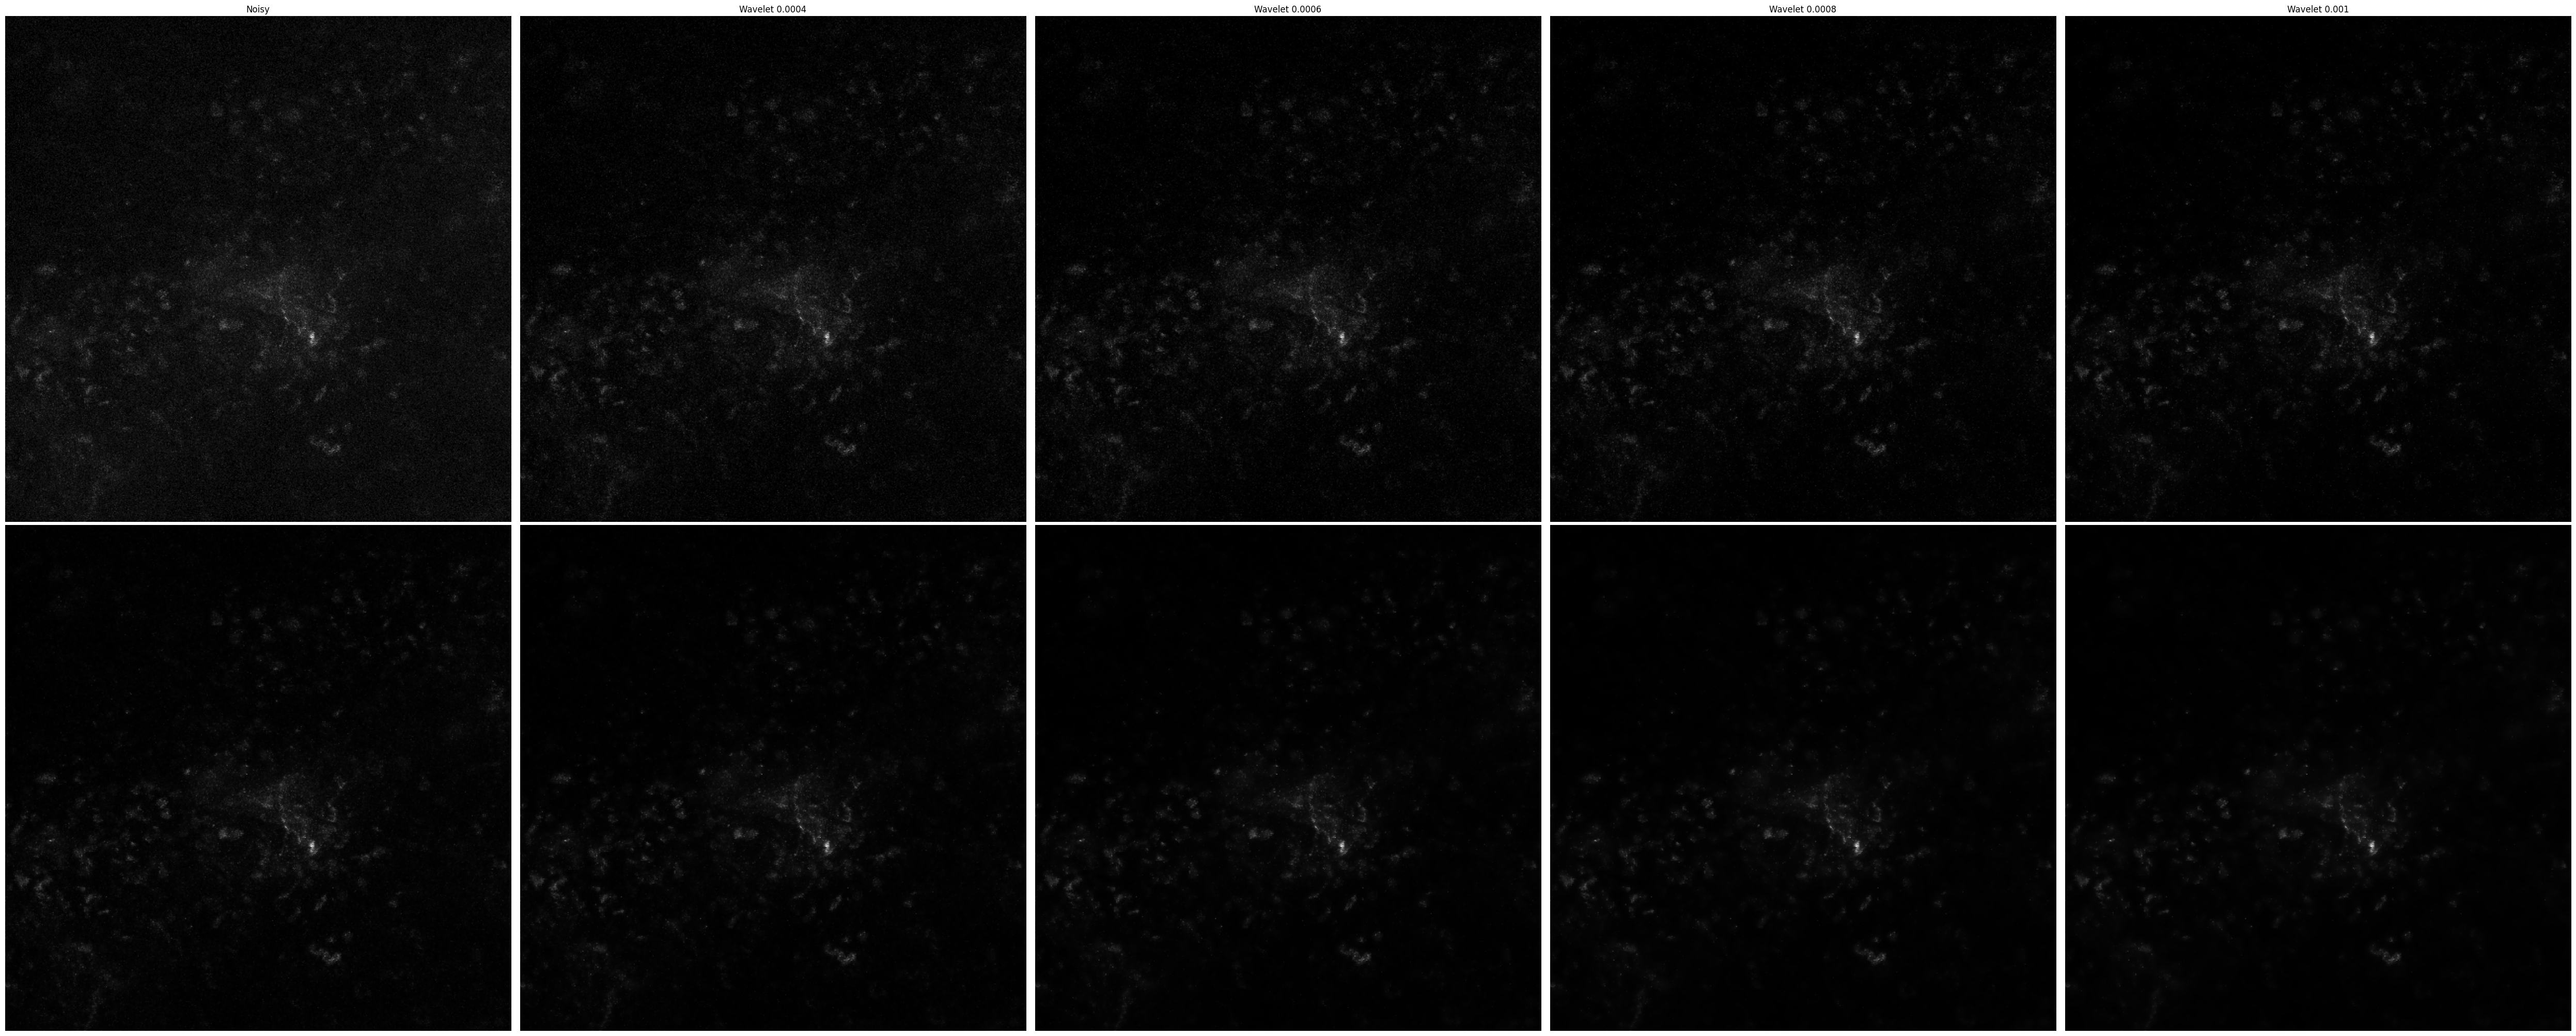

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 20), sharex=True, sharey=True)
ax = ax.flatten()

plt.gray()

ax[0].imshow(np.max(image, axis=0))
ax[0].axis('off')
ax[0].set_title(f'Noisy')

for j, (i, x) in enumerate(im_tv.items()):
    ax[j+1].imshow(np.max(x, axis=0))
    ax[j+1].axis('off')
    ax[j+1].set_title(f'Wavelet {i}')

fig.tight_layout()

plt.show()